In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import yaml

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{amssymb}'

## Figure 1

In [63]:
import torch
from main import CustomDataset


def sample_points(embed_dim = 5000, signal_norm = 15, noise_strength = 0.05):
    train_n = 100
    test_n = 100
    T = 8
    rho = 0.2

    vmu_1 = torch.zeros(embed_dim)
    vmu_2 = torch.zeros(embed_dim)
    vmu_1[0] = signal_norm
    vmu_2[1] = signal_norm

    train_dataset = CustomDataset(train_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.2)
    test_dataset = CustomDataset(test_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.0)
    noise_component = torch.zeros(embed_dim)
    # Add noise component for each noisy training sample
    for i, is_noisy in enumerate(train_dataset.noisy_data_mask):
        if is_noisy:
            noise_component += train_dataset.data[i, 2] - rho * (vmu_1 if train_dataset.label[i] == 1 else vmu_2)
        else:
            noise_component += train_dataset.data[i, 0] - (vmu_1 if train_dataset.label[i] == 1 else vmu_2)

    def calc_attention_scores(x):
        p = (vmu_1 + vmu_2 + noise_strength * noise_component)
        attention_logits = (x @ p).squeeze(-1)
        return torch.softmax(attention_logits, dim=-1).numpy()

    # Projections to vmu_1 and vmu_2 directions. They equal to the 0-th and 1-st components of vectors.
    train_vmu_1 = []
    train_vmu_2 = []
    test_vmu_1 = []
    test_vmu_2 = []
    for x in train_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        train_vmu_1.append(selected_token[0].item())
        train_vmu_2.append(selected_token[1].item())
    for x in test_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        test_vmu_1.append(selected_token[0].item())
        test_vmu_2.append(selected_token[1].item())

    train_count = 0
    test_count = 0
    for i, y in enumerate(train_dataset.label):
        if (train_vmu_1[i] > train_vmu_2[i]) and y == 1:
            train_count += 1
        if (train_vmu_1[i] < train_vmu_2[i]) and y == -1:
            train_count += 1
    for i, y in enumerate(test_dataset.label):
        if (test_vmu_1[i] > test_vmu_2[i]) and y == 1:
            test_count += 1
        if (test_vmu_1[i] < test_vmu_2[i]) and y == -1:
            test_count += 1
    print(f"Train acc: {train_count / len(train_dataset.label)}, Test acc: {test_count / len(test_dataset.label)}")
    return train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_dataset.label, test_dataset.label

Train acc: 1.0, Test acc: 1.0
Train acc: 1.0, Test acc: 0.63
Train acc: 0.8, Test acc: 1.0


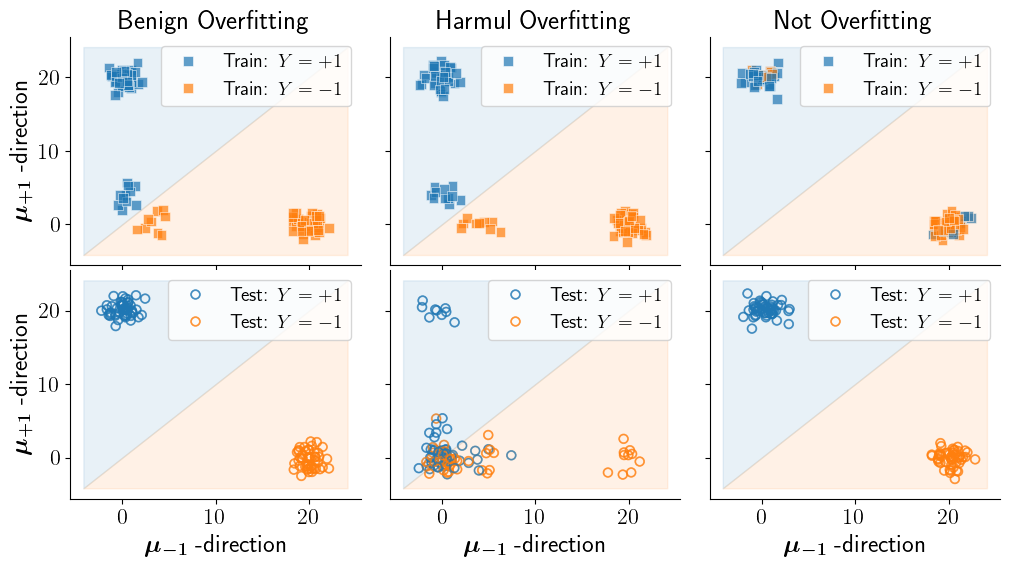

In [ ]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.02, wspace=0.1))

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.06)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][0], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][0], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 1)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][1], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][1], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.001)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][2], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][2], marker='s', palette="tab10", alpha=0.7)

xyrange = (0,0)
for ax in axs.flatten():
    xyrange = (min(xyrange[0], ax.get_xlim()[0], ax.get_ylim()[0]), max(xyrange[1], ax.get_xlim()[1], ax.get_ylim()[1]))

labels = ["Train: $Y=+1$", "Train: $Y=-1$"]
for ax in axs[0]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

labels = ["Test: $Y=+1$", "Test: $Y=-1$"]
for ax in axs[1]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

axs[1][0].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][1].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][2].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)

axs[0][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)
axs[1][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)

axs[0][0].set_title("Benign Overfitting")
axs[0][1].set_title("Harmul Overfitting")
axs[0][2].set_title("Not Overfitting")

plt.show()

/tmp/ipykernel_64982/1317875388.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


Train acc: 1.0, Test acc: 0.62
Train acc: 1.0, Test acc: 1.0
Train acc: 0.8, Test acc: 1.0


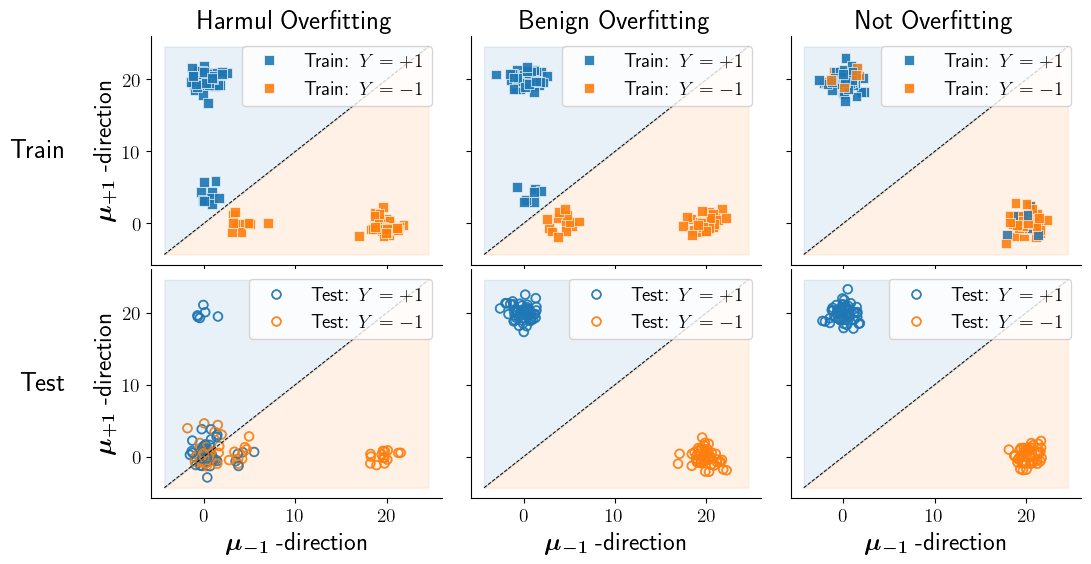

In [134]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.02, wspace=0.1))
cmap = cm.get_cmap("tab10")

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 1)
test_misclassified = np.array([0.9  if (l == 1 and x < y) or (x == -1 and x > y) else 0.5 for (l, x, y) in zip(test_label, test_vmu_1, test_vmu_2)])
train_misclassified = np.array([0.9  if (l == 1 and x < y) or (x == -1 and x > y) else 0.5 for (l, x, y) in zip(train_label, train_vmu_1, train_vmu_2)])

sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][0], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
# colors = [cmap((l + 1) // 2 ) for l in test_label]
# axs[1][0].scatter(test_vmu_1, test_vmu_2, s=50, c=colors, alpha=test_misclassified, marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][0], marker='s', palette="tab10", alpha=0.9)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.06)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][1], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][1], marker='s', palette="tab10", alpha=0.9)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.001)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][2], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][2], marker='s', palette="tab10", alpha=0.9)

xyrange = (0,0)
for ax in axs.flatten():
    xyrange = (min(xyrange[0], ax.get_xlim()[0], ax.get_ylim()[0]), max(xyrange[1], ax.get_xlim()[1], ax.get_ylim()[1]))

labels = ["Train: $Y=+1$", "Train: $Y=-1$"]
# labels = ["$Y=+1$", "$Y=-1$"]
for ax in axs[0]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

labels = ["Test: $Y=+1$", "Test: $Y=-1$"]
# labels = ["$Y=+1$", "$Y=-1$"]
for ax in axs[1]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

x = np.linspace(xyrange[0], xyrange[1], 100)
for ax in axs.flatten():
    ax.plot(x, x, color="black", linestyle="--", linewidth=0.7)
    ax.tick_params(labelsize=14)

for r, ax in zip(["Train", "Test"], axs[:, 0]):
    ax2 = ax.twinx()
    # move extra axis to the left, with offset
    ax2.yaxis.set_label_position('left')
    ax2.spines['left'].set_position(('axes', -0.28))
    # hide spine and ticks, set group label
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_yticks([])
    ax2.set_ylabel(r, rotation=0, size='large',
                   ha='right', va='center')

axs[1][0].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][1].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][2].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)

axs[0][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)
axs[1][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)

axs[0][0].set_title("Harmul Overfitting")
axs[0][1].set_title("Benign Overfitting")
axs[0][2].set_title("Not Overfitting")

plt.show()

In [6]:
plt.rcParams['font.size'] = 18

def find_matching_path_and_dict(condition) -> list[tuple[str, dict]]:
    res = []
    for dir in os.listdir("./outputs"):
        for subdir in os.listdir(os.path.join("./outputs", dir)):
            config_path = os.path.join("./outputs", dir, subdir, ".hydra/config.yaml")
            assert os.path.exists(config_path)
            with open(config_path, "r") as f:
                try:
                    config = yaml.safe_load(f)
                    if condition(config):
                        res.append((os.path.join("./outputs", dir, subdir), config))
                except:
                    pass
    return res

### (a) Balanced Setting

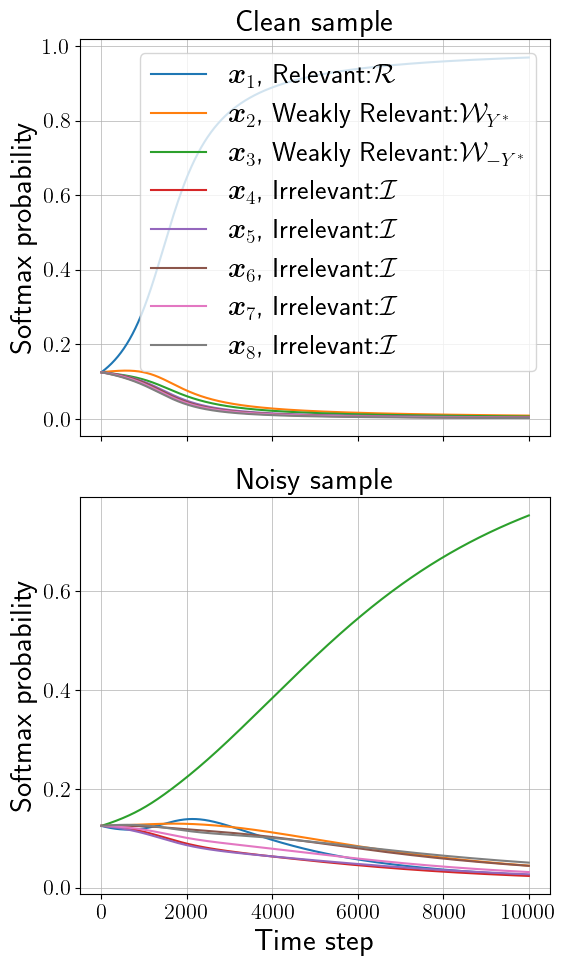

In [21]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20 and x["noise_ratio"] == 0.2)[0][0]
path = "./outputs/2024-09-11/00-36-49"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant:$\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant:$\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant:$\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant:$\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=20)

df = pd.read_csv(os.path.join(path, "attention_scores.csv"))

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


In [2]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20 and x["noise_ratio"] == 0.2)[0][0]
path = "/work/gj24/k36078/benign-attention/outputs/2025-04-07/22-20-50-993775"
df = pd.read_json(os.path.join(path, "stats_time_step.json"))
num_samples = 20
sample_id_clean = num_samples // 2 - 1
sample_id_noisy = 0

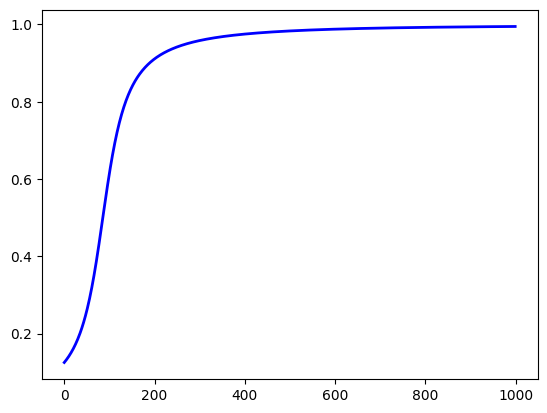

In [ ]:
sample_id = 0
token_id = 0

x = df["time_step"].tolist()
y = df["attention_score"].apply(lambda x: x[sample_id_clean][token_id]).tolist()

plt.plot(x, y, label="Clean sample", color="blue", lw=2)

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant:$\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant:$\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant:$\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant:$\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant:$\mathcal{I}$'
    attention_values = df["attention_score"].iloc[sample_id_clean][token_id]
    axs[0].plot(df["time_step"], df["attention_score"].apply(lambda x: x[sample_id_clean][token_id]), label=label)
    axs[1].plot(df["time_step"], df["attention_score"].apply(lambda x: x[sample_id_noisy][token_id]), label=label)

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=20)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


Error in callback <function _draw_all_if_interactive at 0xfffebd0447c0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp0dwhhqnm bab5324e180e0db746d23d3b7cbac2c8a27edd5753831e551784756ec5827257.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
mktexfmt: mktexfmt is using the following fmtutil.cnf files (in precedence order):
mktexfmt:   /usr/share/texlive/texmf-dist/web2c/fmtutil.cnf
mktexfmt: mktexfmt is using the following fmtutil.cnf file for writing changes:
mktexfmt:   /work/gj24/k36078/.texlive2020/texmf-config/web2c/fmtutil.cnf
mktexfmt [INFO]: writing formats under /work/gj24/k36078/.texlive2020/texmf-var/web2c
mktexfmt [INFO]: --- remaking latex with pdftex
mktexfmt: running `pdftex -ini   -jobname=latex -progname=latex -translate-file=cp227.tcx *latex.ini' ...
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (INITEX)
 restricted \write18 enabled.
 (/usr/share/texlive/texmf-dist/web2c/cp227.tcx)
entering extended mode
(/usr/share/texlive/texmf-dist/tex/latex/latexconfig/latex.ini
(/usr/share/texlive/texmf-dist/tex/generic/tex-ini-files/pdftexconfig.tex)
(/usr/share/texlive/texmf-dist/tex/latex/base/latex.ltx
(/usr/share/texlive/texmf-dist/tex/latex/base/texsys.cfg)
./texsys.aux found


\@currdir set to: ./.


Assuming \openin and \input 
have the same search path.


Defining UNIX/DOS style filename parser.

catcodes, registers, parameters,
LaTeX2e <2020-10-01> patch level 4
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3.ltx
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3-code.tex
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/l3deprecation.def)))
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/xparse/xparse.ltx
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/xparse/xparse-generic.tex))
 hacks, control, par, spacing, files, font encodings, lengths,
====================================

Local config file fonttext.cfg used

====================================
(/usr/share/texlive/texmf-dist/tex/latex/base/fonttext.cfg
(/usr/share/texlive/texmf-dist/tex/latex/base/fonttext.ltx
=== Don't modify this file, use a .cfg file instead ===

(/usr/share/texlive/texmf-dist/tex/latex/base/omlenc.def)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.def)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.def)
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.def)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1cmss.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1cmtt.fd)))
====================================

Local config file fontmath.cfg used

====================================
(/usr/share/texlive/texmf-dist/tex/latex/base/fontmath.cfg
(/usr/share/texlive/texmf-dist/tex/latex/base/fontmath.ltx
=== Don't modify this file, use a .cfg file instead ===

(/usr/share/texlive/texmf-dist/tex/latex/base/omlcmm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/omscmsy.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/omxcmex.fd)
(/usr/share/texlive/texmf-dist/tex/latex/base/ucmr.fd)))
====================================

Local config file preload.cfg used

=====================================
(/usr/share/texlive/texmf-dist/tex/latex/base/preload.cfg
(/usr/share/texlive/texmf-dist/tex/latex/base/preload.ltx)) page nos., x-ref,
environments, center, verbatim, math definitions, boxes, title, sectioning,
contents, floats, footnotes, index, bibliography, output,
===========================================
Local configuration file hyphen.cfg used
===========================================
(/usr/share/texlive/texmf-dist/tex/generic/babel/hyphen.cfg
(/usr/share/texlive/texmf-dist/tex/generic/hyphen/hyphen.tex)
(/usr/share/texlive/texmf-dist/tex/generic/hyphen/dumyhyph.tex)
(/usr/share/texlive/texmf-dist/tex/generic/hyphen/zerohyph.tex))
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu))
No file latex2e-first-aid-for-external-files.ltx.

 ) )
Beginning to dump on file latex.fmt
 (preloaded format=latex 2025.4.7)
18991 strings of total length 340534
277782 memory locations dumped; current usage is 165&275712
17292 multiletter control sequences
\font\nullfont=nullfont
\font\c__fp_exp_intarray=cmr10 at 0.00002pt
\font\c__fp_trig_intarray=cmr10 at 0.00003pt
\font\c_initex_cctab=cmr10 at 0.00005pt
\font\c_other_cctab=cmr10 at 0.00006pt
\font\c_str_cctab=cmr10 at 0.00008pt
\font\g__regex_state_active_intarray=cmr10 at 0.00009pt
\font\g__regex_thread_info_intarray=cmr10 at 0.0001pt
\font\g__regex_submatch_prev_intarray=cmr10 at 0.00012pt
\font\g__regex_submatch_begin_intarray=cmr10 at 0.00014pt
\font\g__regex_submatch_end_intarray=cmr10 at 0.00015pt
\font\g__regex_balance_intarray=cmr10 at 0.00017pt
\font\OMX/cmex/m/n/10=cmex10
\font\tenln=line10
\font\tenlnw=linew10
\font\tencirc=lcircle10
\font\tencircw=lcirclew10
\font\OT1/cmr/m/n/5=cmr5
\font\OT1/cmr/m/n/7=cmr7
\font\OT1/cmr/m/n/10=cmr10
\font\OML/cmm/m/it/5=cmmi5
\font\OML/cmm/m/it/7=cmmi7
\font\OML/cmm/m/it/10=cmmi10
\font\OMS/cmsy/m/n/5=cmsy5
\font\OMS/cmsy/m/n/7=cmsy7
\font\OMS/cmsy/m/n/10=cmsy10
\font\c_code_cctab=cmr10 at 0.00018pt
\font\c_document_cctab=cmr10 at 0.0002pt
403423 words of font info for 27 preloaded fonts
14 hyphenation exceptions
Hyphenation trie of length 6081 has 183 ops out of 35111
  2 for language 1
  181 for language 0
0 words of pdfTeX memory
0 indirect objects
No pages of output.
Transcript written on latex.log.
mktexfmt [INFO]: log file copied to: /work/gj24/k36078/.texlive2020/texmf-var/web2c/pdftex/latex.log
mktexfmt [INFO]: /work/gj24/k36078/.texlive2020/texmf-var/web2c/pdftex/latex.fmt installed.
mktexfmt [INFO]: successfully rebuilt formats: 1
mktexfmt [INFO]: not selected formats: 19
mktexfmt [INFO]: total formats: 20
mktexfmt [INFO]: exiting with status 0
entering extended mode
(./bab5324e180e0db746d23d3b7cbac2c8a27edd5753831e551784756ec5827257.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp0dwhhqnm/bab5324e180e0db746d23d3b7cbac2c8a27edd5753831
e551784756ec5827257.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpvmyzrll4 bab5324e180e0db746d23d3b7cbac2c8a27edd5753831e551784756ec5827257.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./bab5324e180e0db746d23d3b7cbac2c8a27edd5753831e551784756ec5827257.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpvmyzrll4/bab5324e180e0db746d23d3b7cbac2c8a27edd5753831
e551784756ec5827257.log.




<Figure size 600x1000 with 2 Axes>

1.0 0.996


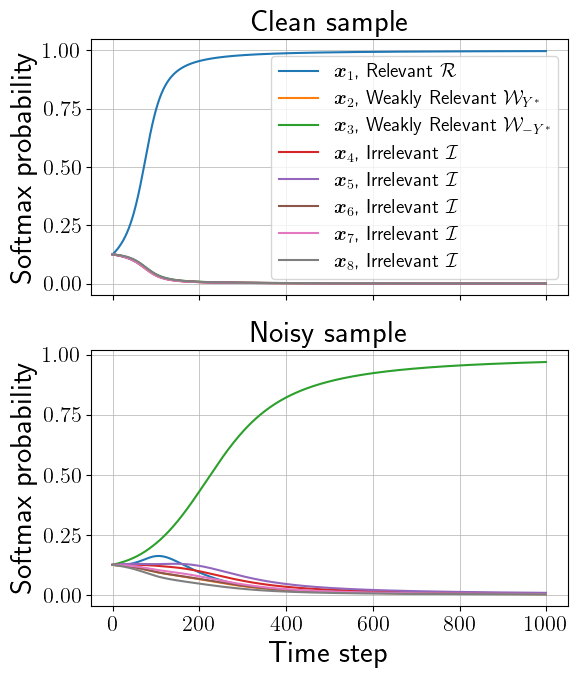

In [16]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20 and x["noise_ratio"] == 0.2)[0][0]
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-12-46"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-18-19"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[1]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


### (a') Large Label Noise (Balanced Setting)

1.0 1.0


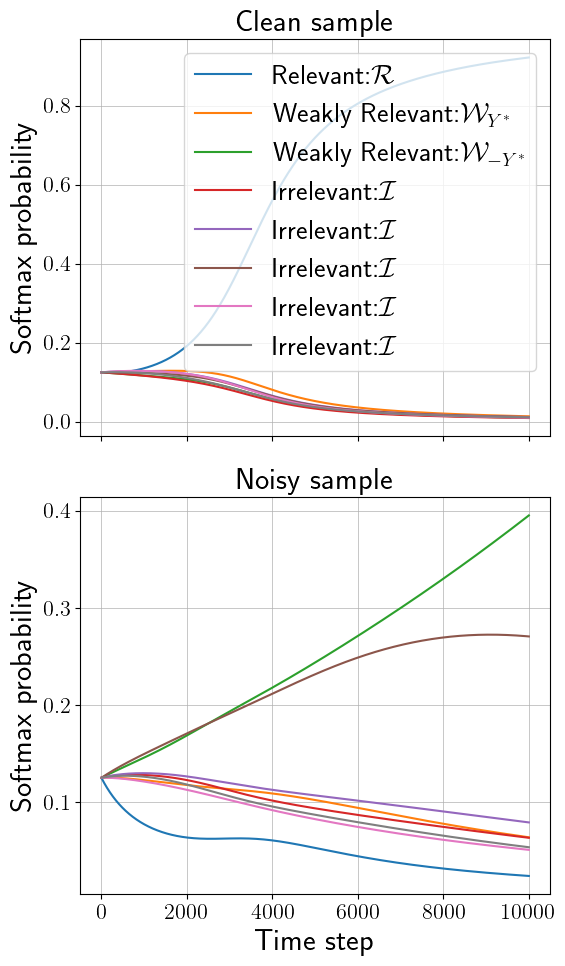

In [9]:
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/0" # noise_ratio=0.3
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/1" # noise_ratio=0.4
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/2" #noise_ratio=0.6

df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        label = r'Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=20)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df["train_accuracy"].values[-1], df["test_accuracy"].values[-1])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


### (b) Large Noise Setting

1.0 0.867


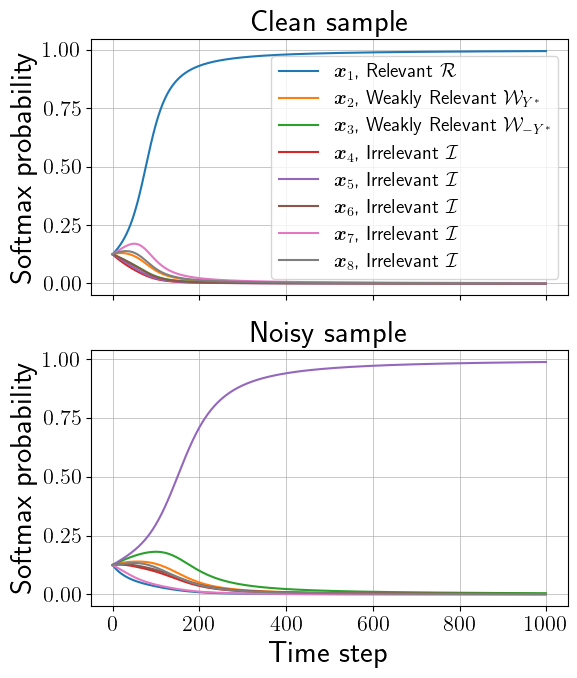

In [15]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 4500 and x["signal_norm"] == 5)[0][0]
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-20-53"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[-1]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

# fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

axs[0].legend(fontsize=14)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

### (c) Large Signal Setting

2 11 0
0.8 1.0


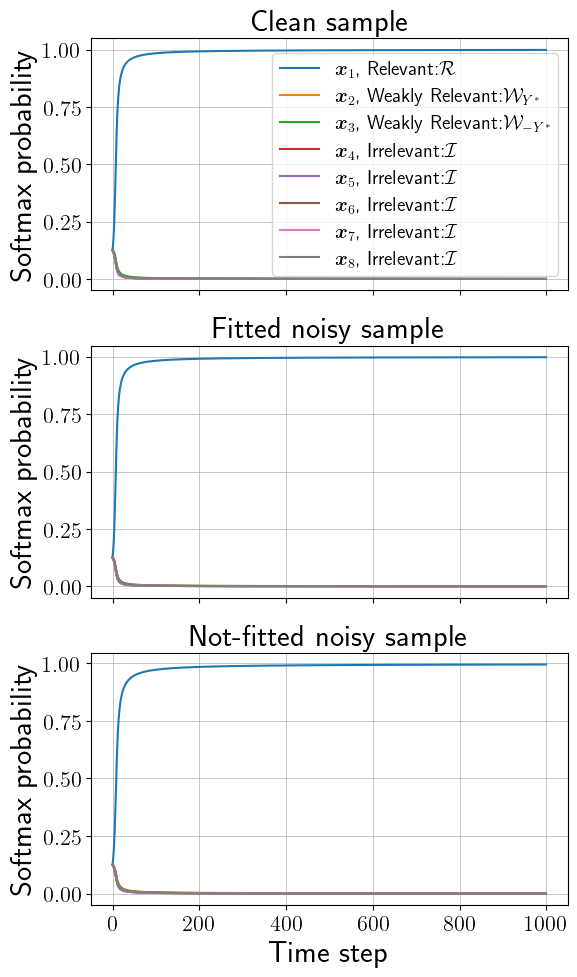

In [7]:
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-13/03-36-54"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-36-17"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = 11
sample_id_noisy_1 = 0
print(sample_id_clean, sample_id_noisy, sample_id_noisy_1)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant:$\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant:$\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant:$\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant:$\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy_1) & (df["token_id"] == token_id)][:1000], ax=axs[1])
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[2])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Fitted noisy sample", fontsize=22)
axs[2].set_title("Not-fitted noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

0.8 1.0


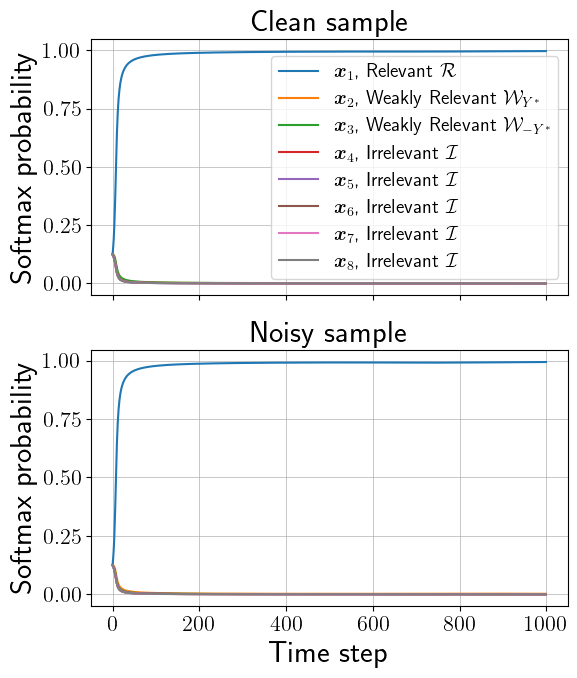

In [3]:
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-13/17-34-34"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-36-17"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = 0

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

## Figure 4

In [6]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key] = {
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1]
            }

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "attention_scores.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key]["max_cumulative_attention"] = df.groupby("time_step", as_index=False)["cumulative_attention"].max()["cumulative_attention"].values[-1]

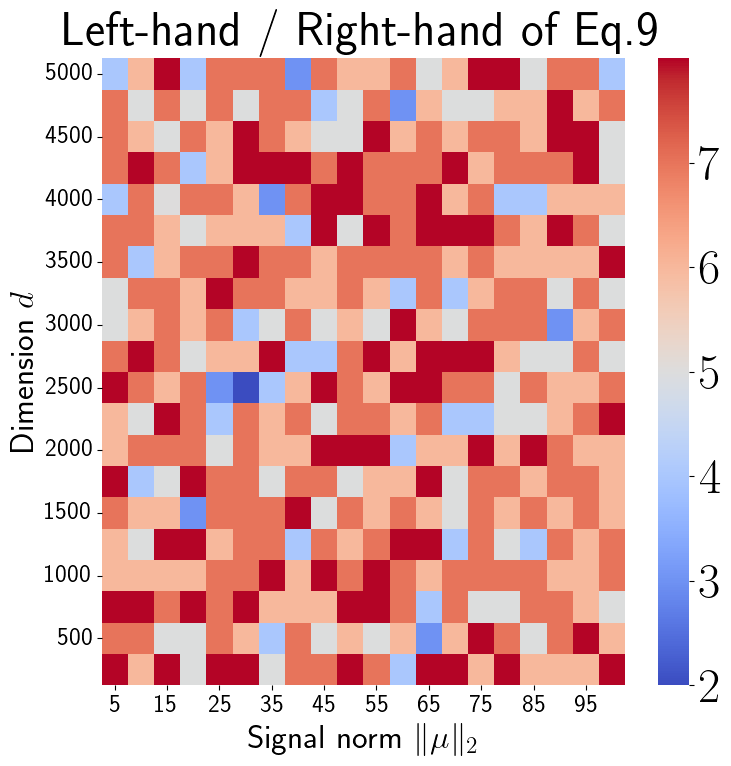

In [7]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = min(res[(ed, sn)]["mathfrak_s_1"], res[(ed, sn)]["mathfrak_s_2"]) / res[(ed, sn)]["max_cumulative_attention"]

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, ax=ax, cmap="coolwarm", annot_kws={"fontsize": 8})

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Left-hand / Right-hand of Eq.9", fontsize=35)
plt.show()

## Figure 5

In [8]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_loss = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_loss[key] = {
                "train_loss": df["train_loss"].values[-1],
                "test_loss": df["test_loss"].values[-1]
            }

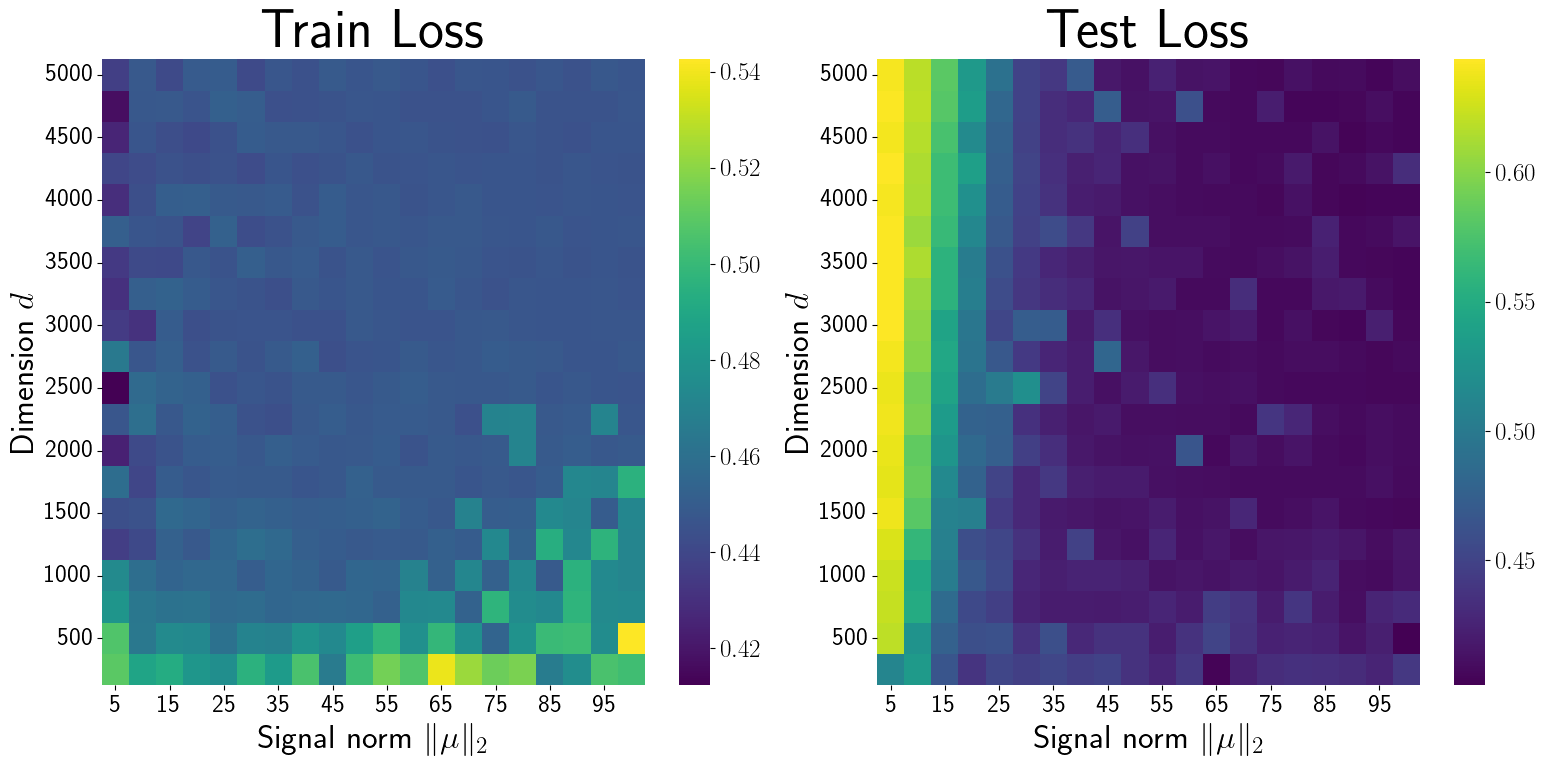

In [9]:
arr_2d_train_loss = np.zeros((20, 20))
arr_2d_test_loss = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d_train_loss[i, j] = res_loss[(ed, sn)]["train_loss"]
        arr_2d_test_loss[i, j] = res_loss[(ed, sn)]["test_loss"]

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis")
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis")

axs[1].set_xticks(axs[0].get_xticks())
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=360)
for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])

    ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

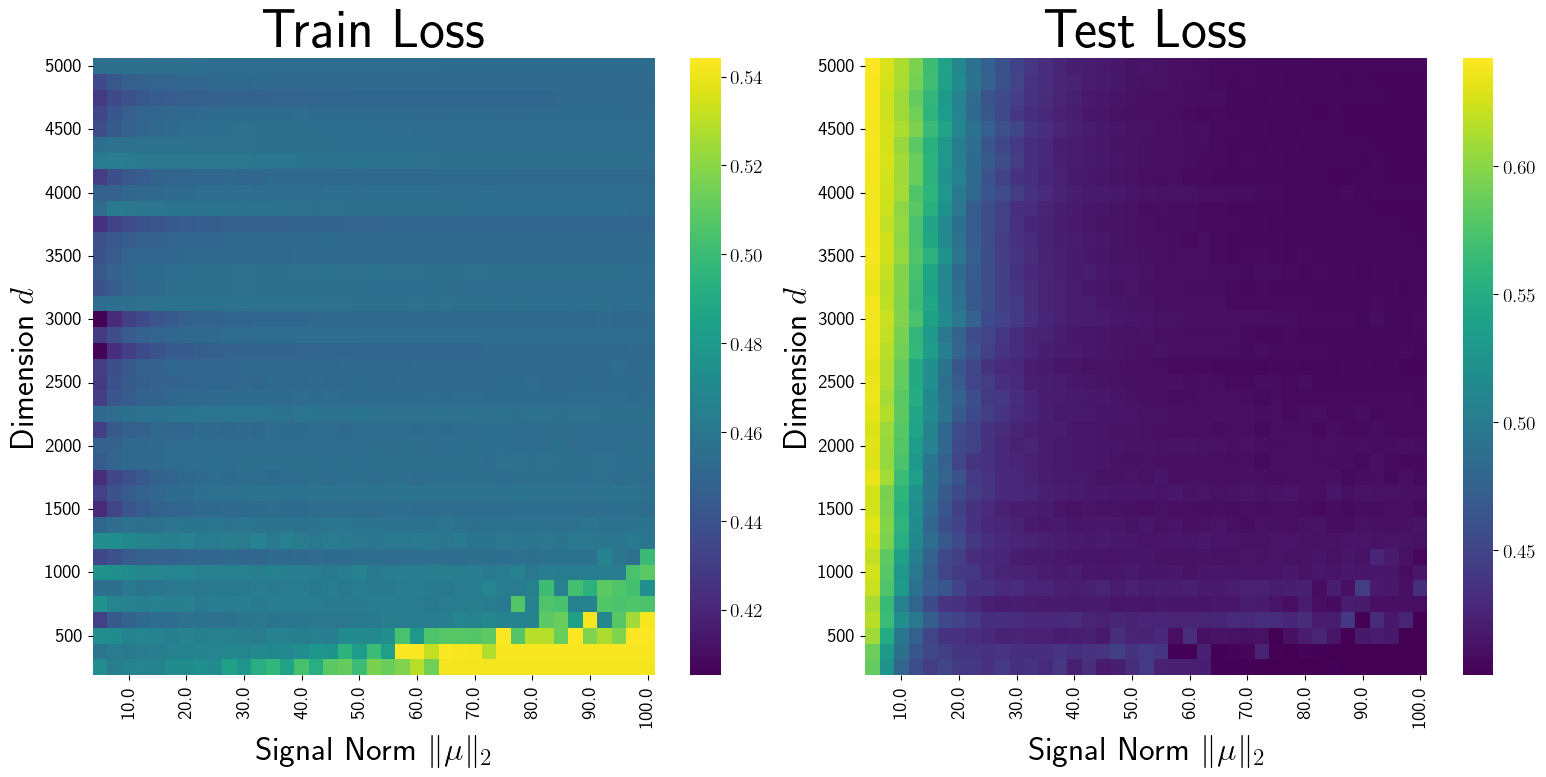

In [15]:
def fetch_dict(ed, sn, rho=0.1):
    if sn == int(sn):
        sn = int(sn)
    csv_path = os.path.join("./results/synthetic", f"d_{ed}", f"signal_{sn}", f"rho_{rho}", "stats_time_step.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} does not exist")
    with open(csv_path, "r") as f:
        df = pd.read_csv(f)
    return df

embed_dim_list = [250 + 125 * i for i in range(39)]
signal_norm_list = [5 + 2.5 * i for i in range(39)]

arr_2d_train_loss = np.zeros((len(embed_dim_list), len(signal_norm_list)))
arr_2d_test_loss = np.zeros((len(embed_dim_list), len(signal_norm_list)))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        df = fetch_dict(ed, sn)
        try:
            arr_2d_train_loss[i, j] = df[df["time_step"] == 999]["train_loss"].values[0]
            arr_2d_test_loss[i, j] = df[df["time_step"] == 999]["test_loss"].values[0]
        except:
            arr_2d_train_loss[i, j] = df[df["time_step"] == 990]["train_loss"].values[0]
            arr_2d_test_loss[i, j] = df[df["time_step"] == 990]["test_loss"].values[0]

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis")
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis")

# axs[1].set_xticks(axs[0].get_xticks())
# axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=360)
for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])
    current_xticks = ax.get_xticks()
    ax.set_xticks(current_xticks[1::2])

    ax.set_xlabel("Signal Norm $\|\mathbf{\mu}\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

## Figure 6

In [10]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_class = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_class[key] = {
                "mathfrak_s_1_0": df["mathfrak_s_1"].values[0],
                "mathfrak_s_2_0": df["mathfrak_s_2"].values[0],
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1],
            }

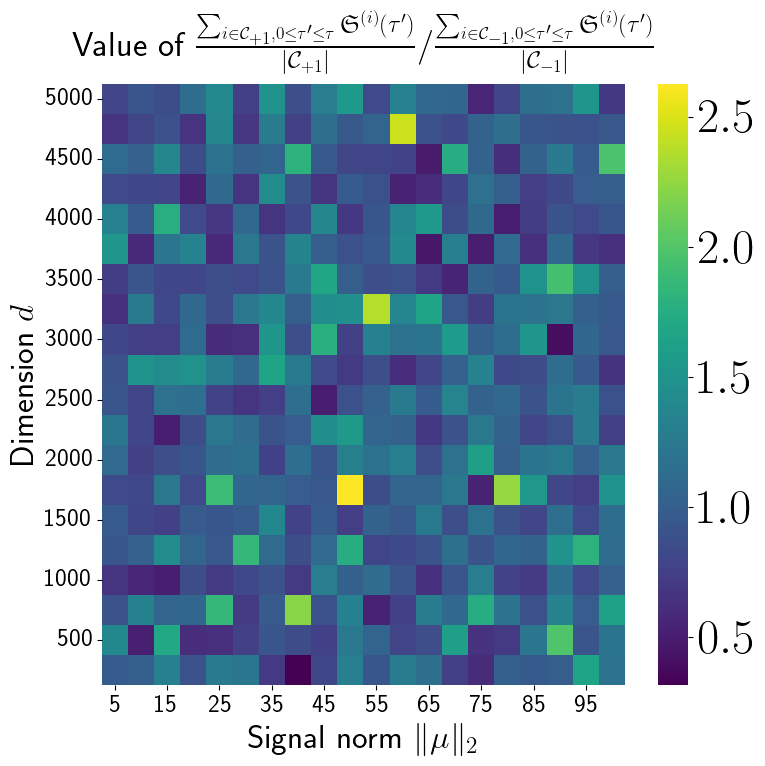

In [11]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = (res_class[(ed, sn)]["mathfrak_s_1"] / res_class[(ed, sn)]["mathfrak_s_2"]) / (res_class[(ed, sn)]["mathfrak_s_1_0"] / res_class[(ed, sn)]["mathfrak_s_2_0"])

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, fmt=".2f", ax=ax, cmap="viridis")

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Value of $\\frac{\sum_{i\in\mathcal{C}_{+1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{+1}|} / \\frac{\sum_{i\in\mathcal{C}_{-1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{-1}|}$", fontsize=25, pad=20)
plt.show()

In [3]:
import os
import numpy as np
import json

model_names = ["vit"] * 5 + ["bert"] * 3
task_names = ["mnist", "cifar10", "stl10", "pneumoniamnist", "breastmnist", "sst2", "agnews", "trec"]
label_noises = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
seeds = [3, 4, 5]

for model_name, task_name in zip(model_names, task_names):
    test_accs = []
    for seed in seeds:
        path = os.path.join("./results", model_name, task_name, "noise_ratio_0.0", "pretrain", str(seed), "trainer_state.json")
        assert os.path.exists(path)
        with open(os.path.join(path), "r") as f:
            trainer_state = json.load(f)
        test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
    print(task_name, f"Baseline: {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")
    for label_noise in label_noises:
        print(f"Noise {label_noise}:", end=" ")
        dir_path = os.path.join("./results", model_name, task_name, f"noise_ratio_{label_noise}", "finetune")
        assert os.path.exists(dir_path)

        train_losses = []
        test_accs = []
        for seed in seeds:
            path = os.path.join(dir_path, str(seed), "trainer_state.json")
            assert os.path.exists(path), f"{path} does not exist"
            with open(os.path.join(path), "r") as f:
                trainer_state = json.load(f)
            train_losses.append(trainer_state["log_history"][-3]["loss"])
            test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
        print(f"{np.mean(train_losses):.2f} +- {np.std(train_losses):.2f}, {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")

mnist Baseline: 93.19 +- 0.17
Noise 0.0: 0.01 +- 0.00, 94.35 +- 0.20
Noise 0.1: 0.12 +- 0.02, 91.92 +- 0.21
Noise 0.2: 0.34 +- 0.05, 90.04 +- 0.86
Noise 0.3: 0.56 +- 0.06, 88.46 +- 0.89
Noise 0.4: 0.81 +- 0.09, 87.74 +- 1.01
Noise 0.5: 1.11 +- 0.10, 85.23 +- 1.01
cifar10 Baseline: 96.03 +- 0.04
Noise 0.0: 0.00 +- 0.00, 96.56 +- 0.09
Noise 0.1: 0.25 +- 0.02, 95.86 +- 0.19
Noise 0.2: 0.52 +- 0.04, 95.22 +- 0.33
Noise 0.3: 0.77 +- 0.06, 94.41 +- 0.32
Noise 0.4: 1.06 +- 0.07, 93.58 +- 0.39
Noise 0.5: 1.36 +- 0.07, 92.86 +- 0.29
stl10 Baseline: 99.52 +- 0.01
Noise 0.0: 0.00 +- 0.00, 99.49 +- 0.02
Noise 0.1: 0.31 +- 0.05, 99.28 +- 0.05
Noise 0.2: 0.66 +- 0.13, 99.05 +- 0.13
Noise 0.3: 0.99 +- 0.17, 98.80 +- 0.14
Noise 0.4: 1.30 +- 0.17, 98.33 +- 0.02
Noise 0.5: 1.69 +- 0.16, 98.00 +- 0.10
pneumoniamnist Baseline: 82.69 +- 0.57
Noise 0.0: 0.00 +- 0.00, 82.80 +- 0.80
Noise 0.1: 0.04 +- 0.01, 84.03 +- 0.92
Noise 0.2: 0.10 +- 0.02, 82.75 +- 0.72
Noise 0.3: 0.14 +- 0.04, 78.42 +- 1.00
Noise 0.4: 

In [8]:
import os
import numpy as np
import json

model_names = ["vit"] * 5 + ["bert"] * 3
task_names = ["mnist", "cifar10", "stl10", "pneumoniamnist", "breastmnist", "sst2", "agnews", "trec"]
label_noises = [0.0, 0.1, 0.2, 0.3, 0.4]
seeds = [3, 4, 5]

for model_name, task_name in zip(model_names, task_names):
    test_accs = []
    for seed in seeds:
        path = os.path.join("./results", model_name, task_name, "noise_ratio_0.0", "pretrain", str(seed), "trainer_state.json")
        assert os.path.exists(path)
        with open(os.path.join(path), "r") as f:
            trainer_state = json.load(f)
        test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
    print(task_name, f"Baseline: {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")
    for label_noise in label_noises:
        print(f"Noise {label_noise}:", end=" ")
        dir_path = os.path.join("./results", model_name, task_name, f"noise_ratio_{label_noise}", "finetune")
        assert os.path.exists(dir_path)

        train_losses = []
        test_accs = []
        for seed in seeds:
            path = os.path.join(dir_path, str(seed), "trainer_state.json")
            assert os.path.exists(path), f"{path} does not exist"
            with open(os.path.join(path), "r") as f:
                trainer_state = json.load(f)
            train_losses.append(trainer_state["log_history"][-3]["loss"])
            test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
        print(f"{np.mean(train_losses):.2f} +- {np.std(train_losses):.2f}, {(np.mean(test_accs)*100):.1f} +- {(np.std(test_accs)*100):.1f}")

mnist Baseline: 93.19 +- 0.17
Noise 0.0: 0.01 +- 0.00, 93.7 +- 0.4
Noise 0.1: 0.10 +- 0.03, 91.4 +- 0.6
Noise 0.2: 0.26 +- 0.10, 89.0 +- 0.6
Noise 0.3: 0.42 +- 0.16, 87.2 +- 0.8
Noise 0.4: 0.60 +- 0.23, 85.9 +- 0.9
cifar10 Baseline: 96.03 +- 0.04
Noise 0.0: 0.00 +- 0.00, 96.5 +- 0.1
Noise 0.1: 0.24 +- 0.03, 95.7 +- 0.1
Noise 0.2: 0.48 +- 0.07, 95.0 +- 0.2
Noise 0.3: 0.70 +- 0.11, 94.2 +- 0.2
Noise 0.4: 0.92 +- 0.14, 93.5 +- 0.4
stl10 Baseline: 99.52 +- 0.01
Noise 0.0: 0.00 +- 0.00, 99.5 +- 0.0
Noise 0.1: 0.32 +- 0.04, 99.2 +- 0.0
Noise 0.2: 0.64 +- 0.14, 99.0 +- 0.1
Noise 0.3: 0.90 +- 0.23, 98.8 +- 0.2
Noise 0.4: 1.14 +- 0.29, 98.4 +- 0.2
pneumoniamnist Baseline: 82.69 +- 0.57
Noise 0.0: 0.00 +- 0.00, 83.0 +- 0.5
Noise 0.1: 0.04 +- 0.01, 84.0 +- 0.3
Noise 0.2: 0.08 +- 0.04, 83.3 +- 1.5
Noise 0.3: 0.12 +- 0.06, 80.2 +- 1.5
Noise 0.4: 0.14 +- 0.07, 80.2 +- 1.7
breastmnist Baseline: 77.99 +- 1.21
Noise 0.0: 0.19 +- 0.02, 81.4 +- 1.8
Noise 0.1: 0.21 +- 0.01, 80.8 +- 2.4
Noise 0.2: 0.20 +- 

In [1]:
import os
import pandas as pd
import yaml
import json

dir = "/work/gu14/k36078/benign-attention/results/mathfrak"
res_class = {}
for dim_dir in os.listdir(dir):
    for signal_dir in os.listdir(os.path.join(dir, dim_dir)):
        for noise_dir in os.listdir(os.path.join(dir, dim_dir, signal_dir)):
            for seed_dir in os.listdir(os.path.join(dir, dim_dir, signal_dir, noise_dir)):
                path = os.path.join(dir, dim_dir, signal_dir, noise_dir, seed_dir)
                assert os.path.exists(path), "{} does not exist".format(path)

                # print(dim_dir, signal_dir, noise_dir, seed_dir)
                with open(os.path.join(path, "stats_time_step.csv"), "r") as f:
                    df = pd.read_csv(f)

                with open(os.path.join(path, "out.json"), "r") as f:
                    out = json.load(f)

                res_class[(dim_dir, signal_dir, seed_dir, noise_dir)] = {
                    "mathfrak_s_1_clean": df["mathfrak_s_1_clean"].values[-1],
                    "mathfrak_s_2_clean": df["mathfrak_s_2_clean"].values[-1],
                    "mathfrak_s_1_noisy": df["mathfrak_s_1_noisy"].values[-1],
                    "mathfrak_s_2_noisy": df["mathfrak_s_2_noisy"].values[-1],
                    "train_accuracy": out["train_accuracy"],
                    "test_accuracy": out["test_accuracy"],
                }

for key in sorted(res_class.keys()):
    print(key)
    # print(res_class[key])
    print(res_class[key]["mathfrak_s_1_clean"] / res_class[key]["mathfrak_s_2_noisy"])
    print(res_class[key]["mathfrak_s_2_clean"] / res_class[key]["mathfrak_s_1_noisy"])
    print(res_class[key]["train_accuracy"])
    print(res_class[key]["test_accuracy"])

('dim_12000', 'signal_120', 'seed_0', 'noise_0.0')
inf
inf
1.0
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.05')
21.50891296880472
21.732389830948733
0.96
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.1')
7.739899431810296
7.790276490999296
0.9
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.15')
4.890610567143059
4.798416438986721
0.86
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.2')
1.658501193342307
1.6298976724660945
0.86
0.999
('dim_12000', 'signal_120', 'seed_0', 'noise_0.25')
1.6219038567727593
1.5944261511211835
0.88
0.995
('dim_12000', 'signal_120', 'seed_0', 'noise_0.3')
1.572973723794079
1.5501710334298908
0.84
0.995
('dim_12000', 'signal_120', 'seed_0', 'noise_0.35')
1.5442561820709162
1.5224753305744296
0.81
0.994
('dim_12000', 'signal_120', 'seed_0', 'noise_0.4')
1.5067887023336932
1.4866775239278833
0.8
0.992
('dim_12000', 'signal_120', 'seed_0', 'noise_0.45')
1.4866286827931885
1.4592628635564502
0.78
0.99
('dim_12000', 'signal_120', 'seed_0', 'noise

/tmp/ipykernel_3081865/1178613074.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  print(res_class[key]["mathfrak_s_1_clean"] / res_class[key]["mathfrak_s_2_noisy"])
/tmp/ipykernel_3081865/1178613074.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  print(res_class[key]["mathfrak_s_2_clean"] / res_class[key]["mathfrak_s_1_noisy"])


In [ ]:
x = df["time_step"].tolist()
y = df["attention_score"].apply(lambda x: x[sample_id_clean][token_id]).tolist()

In [ ]:
# One-layer ViT
# (2000, 20), balanced
# (5000, 5), harmful
# (1000, 100), not

In [3]:
path = "/work/gj24/k36078/benign-attention/outputs/2025-04-08/02-22-36-254937"
df = pd.read_json(os.path.join(path, "stats_time_step.json"))

sample_id = 0
token_id = 2
x = df["time_step"].tolist()
y = df["attention_score"].apply(lambda x: x[sample_id][token_id]).tolist()
print(y[50],y[100], y[200], y[300], y[400], y[500], y[700], y[999])
plt.plot(x, y, label="Clean sample", color="blue", lw=2)


path = "/work/gj24/k36078/benign-attention/outputs/2025-04-08/00-39-13-262213"
df = pd.read_json(os.path.join(path, "stats_time_step.json"))

sample_id = 1
token_id = 2
x = df["time_step"].tolist()
y = df["attention_score"].apply(lambda x: x[sample_id][token_id]).tolist()
print(y[100], y[300], y[500], y[700], y[999])
plt.plot(x, y, label="Clean sample", color="red", lw=2)

0.4400047958 0.7452688217 0.8621495962 0.8913665414 0.9054135084 0.9139811993 0.9242729545 0.9327509403
0.1755771637 0.5194141865 0.8229182363 0.9129128456000001 0.9546642303


Error in callback <function _draw_all_if_interactive at 0xfffed79f05e0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpjcvg__7h 0cf698a207df64b61451d15759c449b40cbe4abb81bfd206a8eb3efcef7c9aa0.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0cf698a207df64b61451d15759c449b40cbe4abb81bfd206a8eb3efcef7c9aa0.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpjcvg__7h/0cf698a207df64b61451d15759c449b40cbe4abb81bfd
206a8eb3efcef7c9aa0.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpvmr2uy43 0cf698a207df64b61451d15759c449b40cbe4abb81bfd206a8eb3efcef7c9aa0.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0cf698a207df64b61451d15759c449b40cbe4abb81bfd206a8eb3efcef7c9aa0.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpvmr2uy43/0cf698a207df64b61451d15759c449b40cbe4abb81bfd
206a8eb3efcef7c9aa0.log.




<Figure size 640x480 with 1 Axes>

In [2]:
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("keitaroskmt/benign_attention_synthetic_vit_one_layer")

In [3]:
embed_dim_list = [250 + 125 * i for i in range(39)]
signal_norm_list = [5 + 2.5 * i for i in range(39)]

print(len(runs))
print(runs[-1].config["embed_dim"])
print(runs[-1].config["embed_dim"] not in embed_dim_list or runs[-1].config["signal_norm"] not in signal_norm_list)
print(runs[-1].summary["train_loss"])
print(runs[-1].state)

1545
3875
False
0.0010642582550644875
finished


In [4]:
embed_dim_list = [250 + 125 * i for i in range(39)]
signal_norm_list = [5 + 2.5 * i for i in range(39)]

arr_2d_train_loss = -np.ones((len(embed_dim_list), len(signal_norm_list)))
arr_2d_test_loss = -np.ones((len(embed_dim_list), len(signal_norm_list)))

for run in runs:
    if run.state != "finished":
        print("not finished")
        continue
    if "job_type" not in run.config["wandb"]:
        print("job_type")
        continue
    if run.config["wandb"]["job_type"] != "heatmap":
        print(run.config["wandb"]["job_type"], "mismatch")
        continue
    if run.config["embed_dim"] not in embed_dim_list or run.config["signal_norm"] not in signal_norm_list:
        print(run.config["embed_dim"], run.config["signal_norm"], "not in embed_dim_list or signal_norm_list")
        continue
    if "train_loss" not in run.summary or "test_loss" not in run.summary:
        print(run.name, run.summary)
    ed = run.config["embed_dim"]
    sn = run.config["signal_norm"]
    i = int((ed - 250) // 125)
    j = int((sn - 5) // 2.5)
    arr_2d_train_loss[i, j] = run.summary["train_loss"]
    arr_2d_test_loss[i, j] = run.summary["test_loss"]

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        if arr_2d_train_loss[i, j] == -1:
            print(f"({ed}, {sn}) not found")

not finished
not finished
not finished
not finished
job_type
not finished
not finished
not finished
job_type
job_type
job_type
job_type
job_type
job_type
job_type
job_type
job_type
job_type
debug mismatch
not finished
attention_dynamics mismatch
attention_dynamics mismatch
attention_dynamics mismatch
attention_dynamics mismatch


<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:18: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_2095168/1684816362.py:18: SyntaxWarning: invalid escape sequence '\|'
  ax.set_xlabel("Signal Norm $\|\mu\|_2$", fontsize=24)


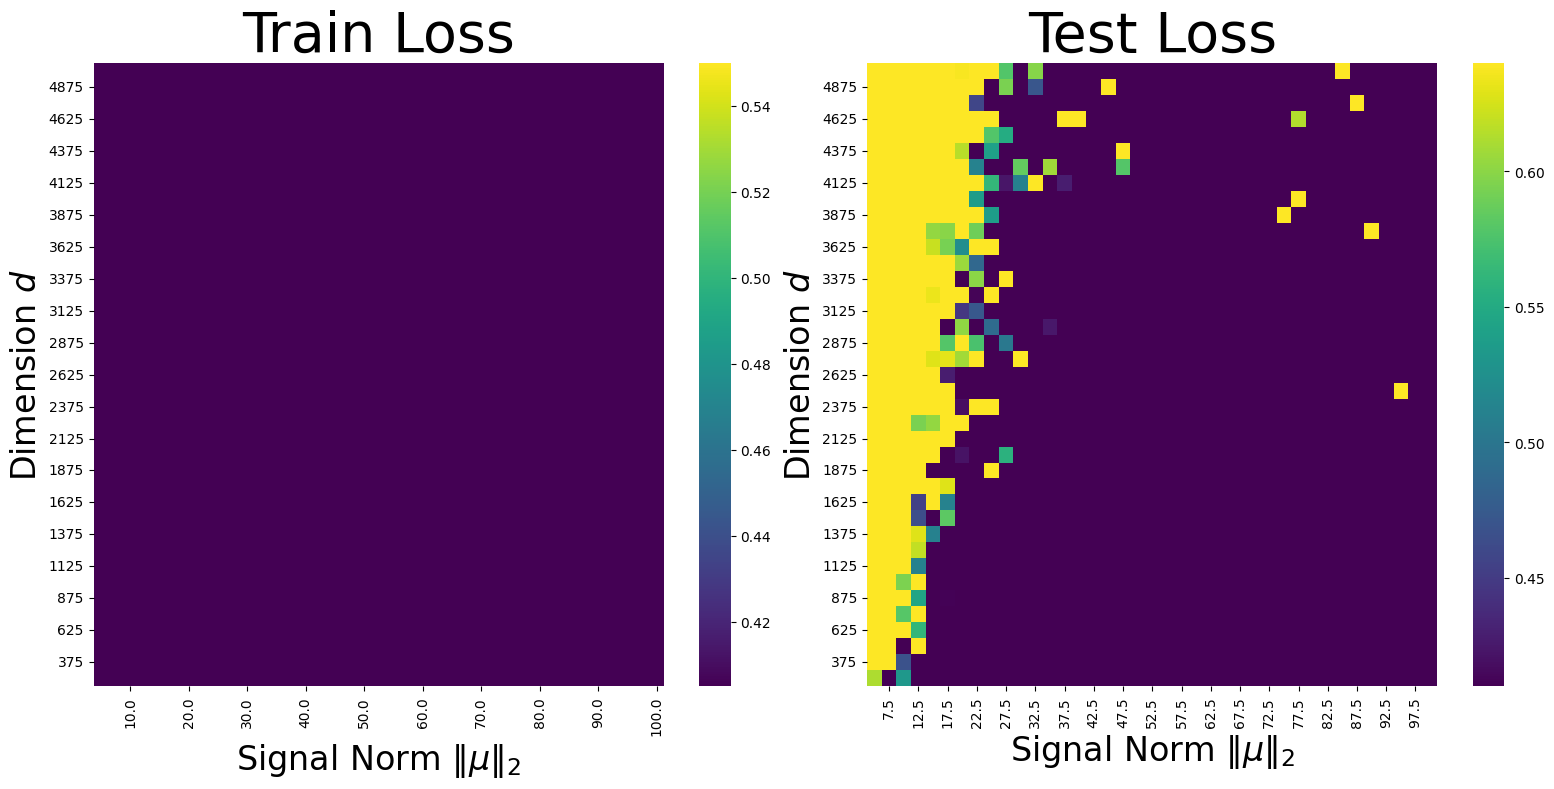

In [10]:
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{amssymb}'

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis", vmin=0.405, vmax=0.55)
# sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis", vmax=0.65)
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis", vmin=0.41, vmax=0.64)

for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])
    current_xticks = ax.get_xticks()
    ax.set_xticks(current_xticks[1::2])

    ax.set_xlabel("Signal Norm $\|\mu\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

In [17]:
path = "/work/gj24/k36078/benign-attention/outputs/2025-04-08/11-31-56-157933"
df = pd.read_json(os.path.join(path, "stats_time_step.json"))
series = df["attention_score"]

In [26]:
series.apply(lambda x: x[0])
print(df["test_accuracy"][900])

0.746


## Large signal setting

Due to the latex rendering error, we only output the raw data and plot the figure in Wisteria

1.0 0.746


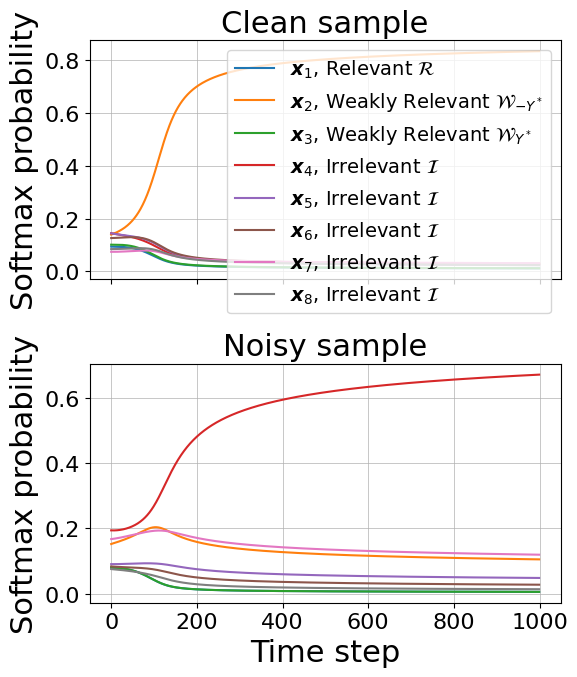

In [8]:
%matplotlib inline

path = "/work/gj24/k36078/benign-attention/outputs/2025-04-08/11-31-56-157933"
df = pd.read_json(os.path.join(path, "stats_time_step.json"))
sample_id_clean = 0 # 1, 10, 11
sample_id_noisy = 2 # otherwise

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{amssymb}'

time_steps = df["time_step"].tolist()
attention_scores_clean = df["attention_score"].apply(lambda x: x[sample_id_clean])
attention_scores_noisy = df["attention_score"].apply(lambda x: x[sample_id_noisy])

fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in [0, 2, 1, 3, 4, 5, 6, 7]:
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x=time_steps, y=attention_scores_clean.apply(lambda x: x[token_id]), ax=axs[0], label=label)
    sns.lineplot(x=time_steps, y=attention_scores_noisy.apply(lambda x: x[token_id]), ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=14)

print(df["train_accuracy"][900], df["test_accuracy"][900])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

In [ ]:
import os
import numpy as np
import json

model_names = ["vit"] * 5 + ["bert"] * 3
task_names = ["mnist", "cifar10", "stl10", "pneumoniamnist", "breastmnist", "sst2", "agnews", "trec"]
label_noises = [0.0, 0.2]
seeds = [42, 314, 2718]
sample_size = [20, 200, 1000]

for model_name, task_name in zip(model_names, task_names):
    test_accs = []
    for seed in seeds:
        path = os.path.join("./results", model_name, task_name, "pretrain", f"seed_{seed}", "trainer_state.json")
        assert os.path.exists(path)
        with open(os.path.join(path), "r") as f:
            trainer_state = json.load(f)
        test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
    print(task_name, f"Baseline: {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")

    for label_noise in label_noises:
        print(f" Noise {label_noise}:")
        for sample in sample_size:
            if sample == 1000 and task_name == "breastmnist":
                continue
            print(f"  Sample size {sample}:", end=" ")
            dir_path = os.path.join("./results", model_name, task_name, "finetune", f"noise_ratio_{label_noise}", f"sample_size_{sample}", "revert_weights_True")
            assert os.path.exists(dir_path)

            train_losses = []
            test_accs = []
            for seed in seeds:
                path = os.path.join(dir_path, f"seed_{seed}", "trainer_state.json")
                assert os.path.exists(path), f"{path} does not exist"
                with open(os.path.join(path), "r") as f:
                    trainer_state = json.load(f)
                train_losses.append(trainer_state["log_history"][-4]["loss"])
                test_accs.append(trainer_state["log_history"][-2]["eval_accuracy"])

            print(f"{np.mean(train_losses):.2f} +- {np.std(train_losses):.2f}, {(np.mean(test_accs)*100):.1f} +- {(np.std(test_accs)*100):.1f}")

mnist Baseline: 95.03 +- 0.06
 Noise 0.0:
  Sample size 20: 0.00 +- 0.00, 90.8 +- 1.5
  Sample size 200: 0.00 +- 0.00, 91.8 +- 0.1
  Sample size 1000: 0.00 +- 0.00, 93.9 +- 0.1
 Noise 0.2:
  Sample size 20: 0.00 +- 0.00, 84.0 +- 7.2
  Sample size 200: 0.04 +- 0.01, 87.3 +- 1.2
  Sample size 1000: 0.14 +- 0.02, 88.4 +- 0.1
cifar10 Baseline: 96.19 +- 0.06
 Noise 0.0:
  Sample size 20: 0.00 +- 0.00, 96.0 +- 0.1
  Sample size 200: 0.00 +- 0.00, 95.9 +- 0.1
  Sample size 1000: 0.00 +- 0.00, 96.3 +- 0.1
 Noise 0.2:
  Sample size 20: 0.18 +- 0.07, 95.5 +- 0.4
  Sample size 200: 0.18 +- 0.01, 94.3 +- 0.3
  Sample size 1000: 0.33 +- 0.02, 93.2 +- 0.1
stl10 Baseline: 99.49 +- 0.02
 Noise 0.0:
  Sample size 20: 0.00 +- 0.00, 99.5 +- 0.0
  Sample size 200: 0.00 +- 0.00, 99.4 +- 0.0
  Sample size 1000: 0.00 +- 0.00, 99.4 +- 0.0
 Noise 0.2:
  Sample size 20: 0.08 +- 0.07, 98.3 +- 1.2
  Sample size 200: 0.24 +- 0.02, 98.5 +- 0.3
  Sample size 1000: 0.37 +- 0.01, 98.3 +- 0.2
pneumoniamnist Baseline: 8

In [1]:
import pandas as pd
import wandb

api = wandb.Api()
# Project is specified by <entity/project-name>
runs = api.runs("keitaroskmt/benign_attention")

In [4]:
dataset_list = ["mnist", "cifar10", "pneumoniamnist", "breastmnist", "agnews", "trec"]
noise_list = [0.01 * i for i in range(21)]

results = {}

for dataset in dataset_list:
    results[dataset] = {}
    for noise in noise_list:
        results[dataset][noise] = {"train_loss": -1, "test_loss": -1, "test_accuracy": -1}
        for run in runs:
            if run.config.get("dataset") is None:
                continue
            if run.state == "finished":
                if run.config["dataset"]["name"] == dataset and run.config["noise_ratio"] == noise and run.config["seed"] == 42:
                    if "eval_train/eval_loss" in run.summary and "eval_test/eval_loss" in run.summary:
                        results[dataset][noise]["train_loss"] = run.summary["eval_train/eval_loss"]
                        results[dataset][noise]["test_loss"] = run.summary["eval_test/eval_loss"]
                        results[dataset][noise]["test_accuracy"] = run.summary["eval_test/eval_accuracy"]

for dataset in dataset_list:
    for noise in noise_list:
        if results[dataset][noise]["train_loss"] == -1:
            print(f"({dataset}, {noise}) not found")
        else:
            print(f"({dataset}, {noise}): {results[dataset][noise]['train_loss']:.4f}, {results[dataset][noise]['test_loss']:.4f}, {results[dataset][noise]['test_accuracy']:.4f}")

(mnist, 0.0): 0.0000, 0.2476, 0.9190
(mnist, 0.01): 0.0001, 0.2519, 0.9188
(mnist, 0.02): 0.0001, 0.2521, 0.9188
(mnist, 0.03): 0.0001, 0.2756, 0.9102
(mnist, 0.04): 0.0001, 0.2870, 0.9025
(mnist, 0.05): 0.0008, 0.3036, 0.8966
(mnist, 0.06): 0.0006, 0.2983, 0.9020
(mnist, 0.07): 0.0030, 0.3102, 0.8956
(mnist, 0.08): 0.0034, 0.3303, 0.8882
(mnist, 0.09): 0.0036, 0.3350, 0.8870
(mnist, 0.1): 0.0045, 0.3474, 0.8808
(mnist, 0.11): 0.0059, 0.3287, 0.8906
(mnist, 0.12): 0.0062, 0.3484, 0.8846
(mnist, 0.13): 0.0056, 0.3580, 0.8807
(mnist, 0.14): 0.0088, 0.3703, 0.8747
(mnist, 0.15): 0.0088, 0.3706, 0.8757
(mnist, 0.16): 0.0218, 0.3994, 0.8703
(mnist, 0.17): 0.0295, 0.3876, 0.8726
(mnist, 0.18): 0.0313, 0.4006, 0.8681
(mnist, 0.19): 0.0293, 0.3981, 0.8672
(mnist, 0.2): 0.0314, 0.4022, 0.8669
(cifar10, 0.0): 0.0000, 0.1390, 0.9582
(cifar10, 0.01): 0.0053, 0.1377, 0.9591
(cifar10, 0.02): 0.0053, 0.1384, 0.9587
(cifar10, 0.03): 0.0062, 0.1403, 0.9583
(cifar10, 0.04): 0.0058, 0.1413, 0.9586
(cifar

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

/tmp/ipykernel_3877885/7789859.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


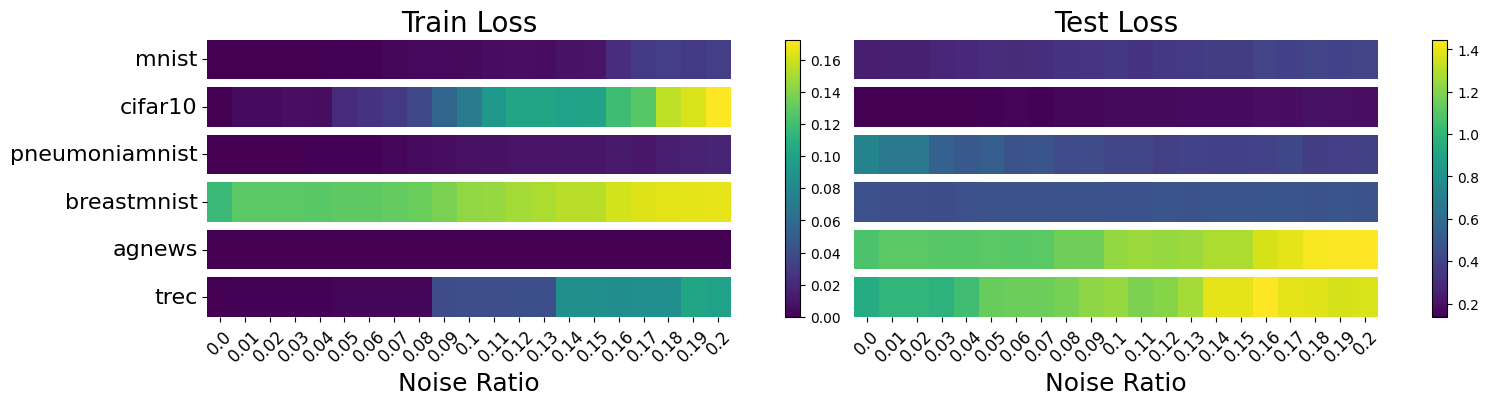

In [81]:
%matplotlib inline

# Prepare data for heatmap
train_loss_data = []
test_loss_data = []

for dataset in dataset_list:
    train_loss_row = []
    test_loss_row = []
    for noise in noise_list:
        train_losses = results[dataset][noise]["train_loss"]
        test_losses = results[dataset][noise]["test_loss"]
        train_loss_row.append(np.mean(train_losses))
        test_loss_row.append(np.mean(test_losses))
    train_loss_data.append(train_loss_row)
    test_loss_data.append(test_loss_row)

# Convert to DataFrame for seaborn
train_loss_df = pd.DataFrame(train_loss_data, index=dataset_list, columns=noise_list)
test_loss_df = pd.DataFrame(test_loss_data, index=dataset_list, columns=noise_list)

# Plot heatmaps
# fig, axs = plt.subplots(len(dataset_list), 2, figsize=(12, len(dataset_list)), sharex=True, sharey=True)
fig = plt.figure(figsize=(16, len(dataset_list) * 0.6))
gs = gridspec.GridSpec(len(dataset_list), 4, width_ratios=[1, 0.03, 1, 0.03], wspace=0.2)

for i, dataset in enumerate(dataset_list):
    ax_train = fig.add_subplot(gs[i, 0])
    ax_test = fig.add_subplot(gs[i, 2])
    hm_train = sns.heatmap(
        train_loss_df.iloc[[i]],
        ax=ax_train,
        cmap="viridis",
        vmin = train_loss_df.min().min(),
        vmax = train_loss_df.max().max(),
        cbar=False,
        xticklabels=i == len(dataset_list) - 1,
        yticklabels=True,
    )

    hm_test = sns.heatmap(
        test_loss_df.iloc[[i]],
        ax=ax_test,
        cmap="viridis",
        vmin = test_loss_df.min().min(),
        vmax = test_loss_df.max().max(),
        cbar=False,
        xticklabels=i == len(dataset_list) - 1,
        yticklabels=False,
    )

    ax_train.set_yticklabels(ax_train.get_yticklabels(), rotation=0, fontsize=16)
    if i == 0:
        ax_train.set_title("Train Loss", fontsize=20)
        ax_test.set_title("Test Loss", fontsize=20)
    if i == len(dataset_list) - 1:
        ax_train.set_xlabel("Noise Ratio", fontsize=18)
        ax_test.set_xlabel("Noise Ratio", fontsize=18)
        ax_train.set_xticklabels(ax_train.get_xticklabels(), rotation=45, fontsize=12)
        ax_test.set_xticklabels(ax_test.get_xticklabels(), rotation=45, fontsize=12)

cax_train = fig.add_subplot(gs[:, 1])
cbar_train = fig.colorbar(hm_train.get_children()[0], cax=cax_train)

cax_test = fig.add_subplot(gs[:, 3])
cbar_test = fig.colorbar(hm_test.get_children()[0], cax=cax_test)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3877885/733017541.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


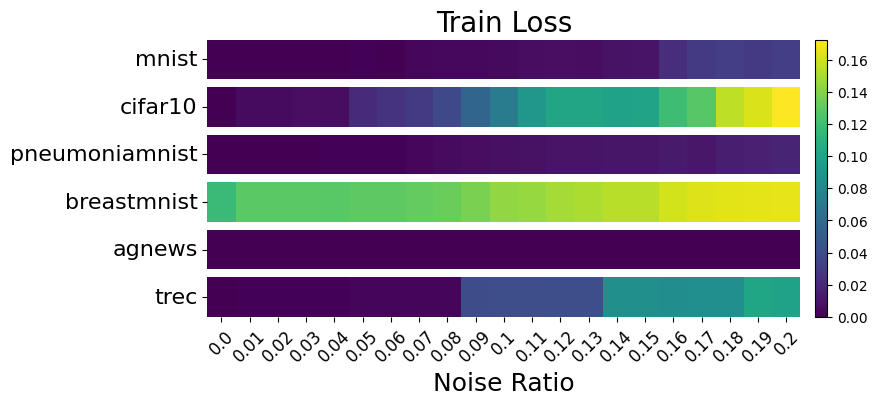

In [93]:
%matplotlib inline

dataset_list = ["mnist", "cifar10", "pneumoniamnist", "breastmnist", "agnews", "trec"]
noise_list = [0.01 * i for i in range(21)]


# Prepare data for heatmap
train_loss_data = []
test_loss_data = []

for dataset in dataset_list:
    train_loss_row = []
    test_loss_row = []
    for noise in noise_list:
        train_losses = results[dataset][noise]["train_loss"]
        test_losses = results[dataset][noise]["test_loss"]
        train_loss_row.append(np.mean(train_losses))
        test_loss_row.append(np.mean(test_losses))
    train_loss_data.append(train_loss_row)
    test_loss_data.append(test_loss_row)

# Convert to DataFrame for seaborn
train_loss_df = pd.DataFrame(train_loss_data, index=dataset_list, columns=noise_list)
test_loss_df = pd.DataFrame(test_loss_data, index=dataset_list, columns=noise_list)

# Plot heatmaps
# fig, axs = plt.subplots(len(dataset_list), 2, figsize=(12, len(dataset_list)), sharex=True, sharey=True)
fig = plt.figure(figsize=(8, len(dataset_list) * 0.6))
gs = gridspec.GridSpec(len(dataset_list), 2, width_ratios=[1, 0.02], wspace=0.05)

for i, dataset in enumerate(dataset_list):
    ax_train = fig.add_subplot(gs[i, 0])
    hm_train = sns.heatmap(
        train_loss_df.iloc[[i]],
        ax=ax_train,
        cmap="viridis",
        vmin = train_loss_df.min().min(),
        vmax = train_loss_df.max().max(),
        cbar=False,
        xticklabels=i == len(dataset_list) - 1,
        yticklabels=True,
    )
    ax_train.set_yticklabels(ax_train.get_yticklabels(), rotation=0, fontsize=16)
    if i == 0:
        ax_train.set_title("Train Loss", fontsize=20)
    if i == len(dataset_list) - 1:
        ax_train.set_xlabel("Noise Ratio", fontsize=18)
        ax_train.set_xticklabels(ax_train.get_xticklabels(), rotation=45, fontsize=12)

cax_train = fig.add_subplot(gs[:, 1])
cbar_train = fig.colorbar(hm_train.get_children()[0], cax=cax_train)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3877885/1565813155.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


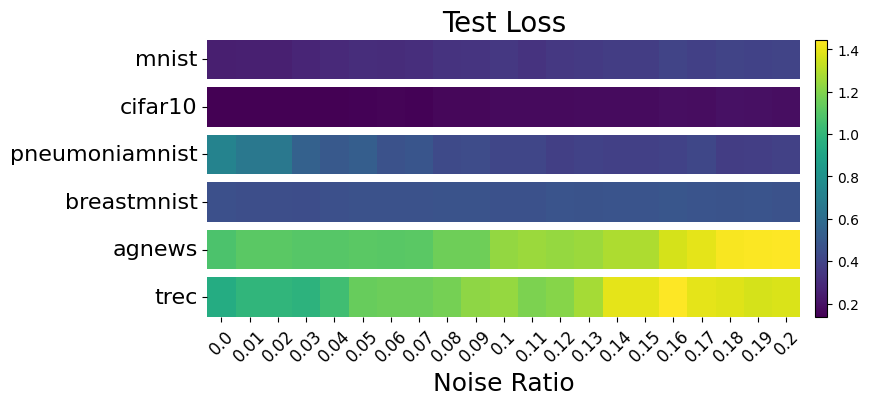

In [94]:
%matplotlib inline

dataset_list = ["mnist", "cifar10", "pneumoniamnist", "breastmnist", "agnews", "trec"]
noise_list = [0.01 * i for i in range(21)]

# Prepare data for heatmap
train_loss_data = []
test_loss_data = []

for dataset in dataset_list:
    train_loss_row = []
    test_loss_row = []
    for noise in noise_list:
        train_losses = results[dataset][noise]["train_loss"]
        test_losses = results[dataset][noise]["test_loss"]
        train_loss_row.append(np.mean(train_losses))
        test_loss_row.append(np.mean(test_losses))
    train_loss_data.append(train_loss_row)
    test_loss_data.append(test_loss_row)

# Convert to DataFrame for seaborn
train_loss_df = pd.DataFrame(train_loss_data, index=dataset_list, columns=noise_list)
test_loss_df = pd.DataFrame(test_loss_data, index=dataset_list, columns=noise_list)

# Plot heatmaps
# fig, axs = plt.subplots(len(dataset_list), 2, figsize=(12, len(dataset_list)), sharex=True, sharey=True)
fig = plt.figure(figsize=(8, len(dataset_list) * 0.6))
gs = gridspec.GridSpec(len(dataset_list), 2, width_ratios=[1, 0.02], wspace=0.05)

for i, dataset in enumerate(dataset_list):
    ax_test = fig.add_subplot(gs[i, 0])
    hm_test = sns.heatmap(
        test_loss_df.iloc[[i]],
        ax=ax_test,
        cmap="viridis",
        vmin = test_loss_df.min().min(),
        vmax = test_loss_df.max().max(),
        cbar=False,
        xticklabels=i == len(dataset_list) - 1,
        yticklabels=True,
    )
    ax_test.set_yticklabels(ax_test.get_yticklabels(), rotation=0, fontsize=16)
    if i == 0:
        ax_test.set_title("Test Loss", fontsize=20)
    if i == len(dataset_list) - 1:
        ax_test.set_xlabel("Noise Ratio", fontsize=18)
        ax_test.set_xticklabels(ax_test.get_xticklabels(), rotation=45, fontsize=12)

cax_test = fig.add_subplot(gs[:, 1])
cbar_test = fig.colorbar(hm_test.get_children()[0], cax=cax_test)

plt.tight_layout()
plt.show()

In [95]:
import pandas as pd
import wandb

api = wandb.Api()
# Project is specified by <entity/project-name>
runs = api.runs("keitaroskmt/benign_attention")

In [ ]:
dataset_list = ["mnist", "cifar10", "pneumoniamnist", "breastmnist", "agnews", "trec"]
noise_list = [0.01 * i for i in range(21)]

results = {}

for dataset in dataset_list:
    results[dataset] = {}
    for noise in noise_list:
        results[dataset][noise] = {"train_loss": -1, "test_loss": -1, "test_accuracy": -1}
        for run in runs:
            if run.config.get("dataset") is None:
                continue
            if run.state == "finished":
                if run.config["dataset"]["name"] == dataset and run.config["noise_ratio"] == noise and run.config["seed"] == 42:
                    if "eval_train/eval_loss" in run.summary and "eval_test/eval_loss" in run.summary:
                        results[dataset][noise]["train_loss"] = run.summary["eval_train/eval_loss"]
                        results[dataset][noise]["test_loss"] = run.summary["eval_test/eval_loss"]
                        results[dataset][noise]["test_accuracy"] = run.summary["eval_test/eval_accuracy"]

for dataset in dataset_list:
    for noise in noise_list:
        if results[dataset][noise]["train_loss"] == -1:
            print(f"({dataset}, {noise}) not found")
        else:
            print(f"({dataset}, {noise}): {results[dataset][noise]['train_loss']:.4f}, {results[dataset][noise]['test_loss']:.4f}, {results[dataset][noise]['test_accuracy']:.4f}")

In [96]:
run = api.run("keitaroskmt/benign_attention/8g5z5ff0")

In [97]:
run.history(keys=["mean_max_cls_attention"])

,_step,mean_max_cls_attention
0,0,0.006267
1,1,0.006289
2,2,0.006300


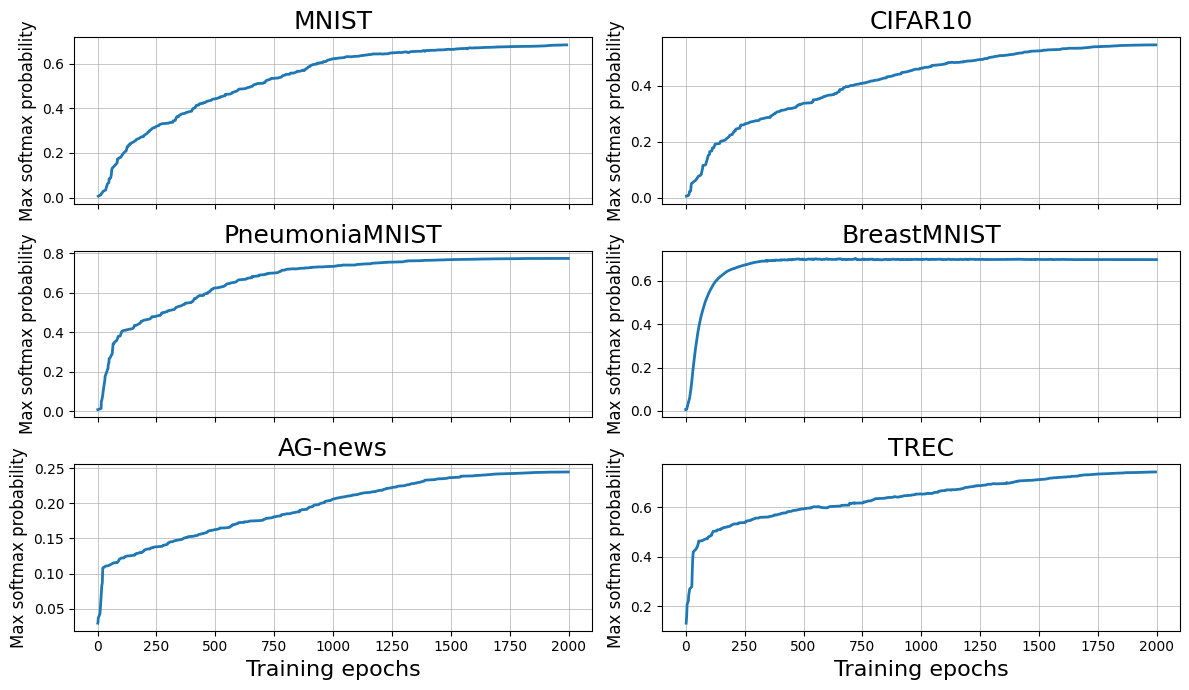

In [110]:
run_path = {
    "MNIST": "keitaroskmt/benign_attention/6isn0izl",
    "CIFAR10": "keitaroskmt/benign_attention/1274b1eq",
    "PneumoniaMNIST": "keitaroskmt/benign_attention/47chn8me",
    "BreastMNIST": "keitaroskmt/benign_attention/vr1b66qr",
    "AG-news": "keitaroskmt/benign_attention/ts2u3p5b",
    "TREC": "keitaroskmt/benign_attention/7ffnfjro",
}

fig, axs = plt.subplots(3, 2, figsize=(12, 7), tight_layout=True, sharex=True)

for i, (k, v) in enumerate(run_path.items()):
    ax = axs[i // 2][i % 2]
    run = api.run(v)
    sns.lineplot(x=run.history(keys=["mean_max_cls_attention"])["_step"], y=run.history(keys=["mean_max_cls_attention"])["mean_max_cls_attention"], ax=ax, lw=2)
    ax.set_title(k, fontsize=18)
    ax.set_xlabel("Training epochs", fontsize=16)
    ax.set_ylabel("Max softmax probability", fontsize=12)
    ax.grid(lw=0.5)